# Imdb Sentiment Analysis - Group 7

Import Necessary modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Upload all data into dataframe.

In [2]:
base_path = 'aclImdb'

labels = {'pos':1,'neg':0}

#Declare Dataframes for Traning and Testing Datasets
df_train = pd.DataFrame(columns=['data', 'label'])
df_test = pd.DataFrame(columns=['data', 'label'])

#Extract data from train folder 
for i in ('neg','pos'):
    path = os.path.join(base_path,'train',i)
    for filename in os.listdir(path):
        with open(os.path.join(path,filename),'r',encoding = 'utf-8') as infile:
            text = infile.read()    
        df_train = df_train.append({'data':text,'label':labels[i]},ignore_index=True)
#Extract data from test folder
for i in ('neg','pos'):
    path = os.path.join(base_path,'test',i)
    for filename in os.listdir(path):
        with open(os.path.join(path,filename),'r',encoding = 'utf-8') as infile:
            text = infile.read()    
        df_test = df_test.append({'data':text,'label':labels[i]},ignore_index=True)


In [3]:
#Save data in csv file
df_train.to_csv('imdb_d-set_train.csv')
df_test.to_csv('imdb_d-set_test.csv')

In [4]:
#Upload train and test datasets from csv
df_train = pd.read_csv('imdb_d-set_train.csv')
df_test = pd.read_csv('imdb_d-set_test.csv')

Training set distribution - Plot

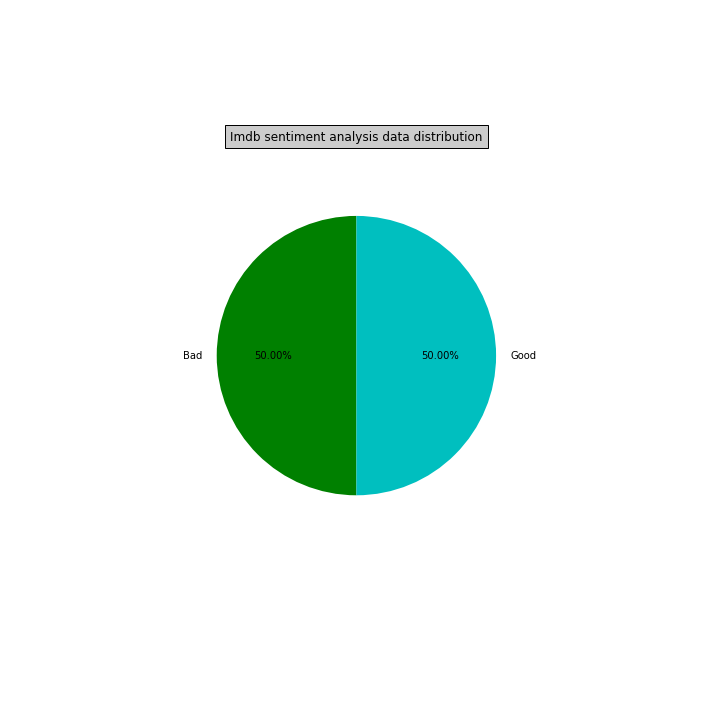

In [5]:
Target, counts = np.unique(df_train['label'], return_counts =True)

Total_Instances = counts[0]+counts[1]
Bad_Percent = (counts[0]/Total_Instances)*100
Good_Percent = (counts[1]/Total_Instances)*100

col = 'g','c'
Plot_Lables = 'Bad','Good'
Plot_Sizes = [Bad_Percent, Good_Percent]
plt.figure(figsize=(10, 10))
plt.title('Imdb sentiment analysis data distribution',bbox={'facecolor':'0.8', 'pad':5},x=0.5,y=0.8)
plt.pie(Plot_Sizes,labels=Plot_Lables,radius=0.5,colors=col, autopct='%1.2f%%', startangle=90)
plt.savefig('Target_Distribution.png')
plt.tight_layout()
plt.show()

Data Cleaning and Processing.

In [6]:
import nltk
import re

dataSet_train = df_train ['data']
dataSet_test = df_test ['data']

#Lowercase all data
dataSet_train= dataSet_train.map(lambda x: x.lower())
dataSet_test= dataSet_test.map(lambda x: x.lower())

#Remove-Stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWord = stopwords.words('english')
dataSet_train.apply(lambda x: [item for item in x if item not in stopWord])
dataSet_test.apply(lambda x: [item for item in x if item not in stopWord])

#Cleanup
def cleanup(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return re.sub('\[[^]]*\]', '', text)

dataSet_train = dataSet_train.apply(cleanup)
dataSet_test = dataSet_test.apply(cleanup)

#Lemma
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
dataSet_train = [wordnet_lemmatizer.lemmatize(word) for word in dataSet_train]
dataSet_test = [wordnet_lemmatizer.lemmatize(word) for word in dataSet_test]

#Stem
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
dataSet_train = [stemmer.stem(word) for word in dataSet_train]
dataSet_test = [stemmer.stem(word) for word in dataSet_test]

#Fit-data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

train_label = df_train['label']
Y_train = train_label.astype('int')
vector = CountVectorizer(binary=True, ngram_range=(1,2))
train_data = vector.fit_transform(dataSet_train)
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(train_data)

test_label = df_test['label']
Y_test = train_label.astype('int')
test_data = vector.transform(dataSet_test)
X_test = tfidf_transformer.transform(test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shuffle train dataset

In [7]:
from sklearn.utils import shuffle

X_train,Y_train= shuffle (X_train,Y_train, random_state = 10)

ML Models:

1. Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

#Use GridSearch Cross Validation to tune the hyperparameters 
log_pipe = Pipeline([('lr_clf', LogisticRegression(solver = 'lbfgs', max_iter=500))])
parameters = {'lr_clf__C': (0.1,1,5,10,)}

gs_log = GridSearchCV(log_pipe, parameters, cv=5, scoring='accuracy')
gs_log.fit(X_train,Y_train)
print(np.round(gs_log.cv_results_['mean_test_score']*100,4))
best_pars_lr = gs_log.best_params_
print ("Best_Parameter:",best_pars_lr)

#Using the best hyperparameter(s) - predict on the test dataset.
lr = LogisticRegression(C=best_pars_lr['lr_clf__C'], solver = 'lbfgs', max_iter=500)
lr.fit(X_train,Y_train)
Y_predict = lr.predict(X_test)
print ("Accuracy_LR:", accuracy_score(Y_test,Y_predict))

[86.    88.9   89.9   90.136]
Best_Parameter: {'lr_clf__C': 10}
Accuracy_LR: 0.90612


2. Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

#Use GridSearch Cross Validation to tune the hyperparameters
dec_pipe = Pipeline([('dt_clf', DecisionTreeClassifier(splitter = 'best')),])
parameters = { 'dt_clf__max_depth': (10,20,40)}

gs_dec = GridSearchCV(dec_pipe, parameters, cv=5, scoring='accuracy')
gs_dec = gs_dec.fit(X_train,Y_train)
print(np.round(gs_dec.cv_results_['mean_test_score']*100,4))
best_pars_dt = gs_dec.best_params_
print ("Best_Parameter:",best_pars_dt)

#Using the best hyperparameter(s) - predict on the test dataset.
dt = DecisionTreeClassifier(criterion='gini',max_depth=best_pars_dt['dt_clf__max_depth'])
dt.fit(X_train,Y_train)
Y_predict = dt.predict(X_test)
print ("Accuracy_DT:", accuracy_score(Y_test,Y_predict))

[71.516 71.596 70.716]
Best_Parameter: {'dt_clf__max_depth': 20}
Accuracy_DT: 0.72056


3. Support Vector Machine

In [10]:
from sklearn.svm import LinearSVC

#Use GridSearch Cross Validation to tune the hyperparameters
svm_pipe = Pipeline([('svm_clf', LinearSVC(max_iter = 10000))])
parameters = {'svm_clf__C': (0.7,0.8,1)}

gs_svm = GridSearchCV(svm_pipe, parameters, cv=5, scoring='accuracy')
gs_svm = gs_svm.fit(X_train,Y_train)
print(np.round(gs_svm.cv_results_['mean_test_score']*100,4))
best_pars_svm = gs_svm.best_params_
print ("Best_Parameter:",best_pars_svm)

#Using the best hyperparameter(s) - predict on the test dataset.
svm = LinearSVC(random_state=0, tol=1e-5,C=best_pars_svm['svm_clf__C'])
svm.fit(X_train,Y_train)
Y_predict = svm.predict(X_test)
print ("Accuracy_SVM:", accuracy_score(Y_test,Y_predict))

[90.428 90.46  90.488]
Best_Parameter: {'svm_clf__C': 1}
Accuracy_SVM: 0.90828


4. AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier

#Use GridSearch Cross Validation to tune the hyperparameters
ada_pipe = Pipeline([('ada_clf', AdaBoostClassifier())])
parameters = {
    'ada_clf__learning_rate': (0.1, 1),
    'ada_clf__n_estimators': (10,20)}

gs_ada = GridSearchCV(ada_pipe, parameters, cv=5, scoring='accuracy')
gs_ada = gs_ada.fit(X_train,Y_train)
print(np.round(gs_ada.cv_results_['mean_test_score']*100,4))
best_pars_ada = gs_ada.best_params_
print ("Best_Parameter:",best_pars_ada)

#Using the best hyperparameter(s) - predict on the test dataset.
ab = AdaBoostClassifier(learning_rate=best_pars_ada['ada_clf__learning_rate'],n_estimators=best_pars_ada['ada_clf__n_estimators'])
ab.fit(X_train,Y_train)
Y_predict = ab.predict(X_test)
print ("Accuracy_AB:", accuracy_score(Y_test,Y_predict))


[67.    68.392 72.184 75.676]
Best_Parameter: {'ada_clf__learning_rate': 1, 'ada_clf__n_estimators': 20}
Accuracy_AB: 0.75524


5. Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

#Use GridSearch Cross Validation to tune the hyperparameters
rndm_pipe = Pipeline([('rndm_clf', RandomForestClassifier(bootstrap = True, criterion = 'gini', n_estimators=300))])
parameters = {'rndm_clf__max_depth': (10, 20, 40)}

gs_rndm = GridSearchCV(rndm_pipe, parameters, cv=5, scoring='accuracy')
gs_rndm = gs_rndm.fit(X_train, Y_train)
print(np.round(gs_rndm.cv_results_['mean_test_score']*100,4))
best_pars_rndm = gs_rndm.best_params_
print ("Best_Parameter:",best_pars_rndm)

#Using the best hyperparameter(s) - predict on the test dataset.
rf = RandomForestClassifier(max_depth=best_pars_rndm['rndm_clf__max_depth'], n_estimators=300)
rf.fit(X_train,Y_train)
Y_predict = rf.predict(X_test)
print ("Accuracy_RF:", accuracy_score(Y_test,Y_predict))


[82.936 84.36  85.012]
Best_Parameter: {'rndm_clf__max_depth': 40}
Accuracy_RF: 0.8508


6. MultinomialNB 

In [13]:
from sklearn.naive_bayes import MultinomialNB

#Use GridSearch Cross Validation to tune the hyperparameters
nb_pipe = Pipeline([('nb_clf', MultinomialNB())])
parameters = {
    'nb_clf__alpha': (0.1,1,2,5)}

gs_nb = GridSearchCV(nb_pipe, parameters, cv=5, scoring='accuracy')
gs_nb = gs_nb.fit(X_train,Y_train)
print(np.round(gs_nb.cv_results_['mean_test_score']*100,4))
best_pars_nb = gs_nb.best_params_
print ("Best_Parameter:",best_pars_nb)

#Using the best hyperparameter(s) - predict on the test dataset.
nb = MultinomialNB(alpha=best_pars_nb['nb_clf__alpha'])
nb.fit(X_train,Y_train)
Y_predict = nb.predict(X_test)
print ("Accuracy_RF:", accuracy_score(Y_test,Y_predict))

[89.316 88.656 88.14  87.128]
Best_Parameter: {'nb_clf__alpha': 0.1}
Accuracy_RF: 0.8746
